In [1]:
import os
import sys

import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
sys.path.insert(0, '../src')

from utils import *

In [3]:
sns.set(rc={'figure.figsize':(20,5)})

In [512]:
def load_data(resolution):
  data_filepath = "../data/" + resolution + "/"
  data_dir = os.listdir(data_filepath)
  return [add_resolution(data_filepath + fp, resolution) for fp in data_dir]

In [515]:
%%time
mbit_rate = 1/125000

df_240_lst = load_data('240p')
df_360_lst = load_data('360p')
df_480_lst = load_data('480p')
df_720_lst = load_data('720p')
df_1080_lst = load_data('1080p')

chunk_size = 300
chunk_240_lst = sum([chunk_data(df, chunk_size) for df in df_240_lst], [])
chunk_360_lst = sum([chunk_data(df, chunk_size) for df in df_360_lst], [])
chunk_480_lst = sum([chunk_data(df, chunk_size) for df in df_480_lst], [])
chunk_720_lst = sum([chunk_data(df, chunk_size) for df in df_720_lst], [])
chunk_1080_lst = sum([chunk_data(df, chunk_size) for df in df_1080_lst], [])

Wall time: 9.09 s


In [5]:
two_four_path = [two_four_fp + fp for fp in two_four_dir]
three_six_path = [three_six_fp + fp for fp in three_six_dir]
four_eight_path = [four_eight_fp + fp for fp in four_eight_dir]
seven_two_path = [seven_two_fp + fp for fp in seven_two_dir]
ten_eight_path = [ten_eight_fp + fp for fp in ten_eight_dir]

## Aggregate Features
In our EDA, we saw significant differences in aggregate statistics such as the mean and standard deviation. We reconfirm this by taking our chunked data and performing said operations. There seems to be alot of potential colinearity between the bytes and packet stream statistics (strong positive correlation). In our model, we chose to take the aggregate features of just the download stream of bytes as a way of thresholding bandwidth usage.

In [225]:
def mean_features_all(df_lst):
  mean_feat = [[
    np.mean(df['2->1Bytes']) * mbit_rate,
    np.mean(df['1->2Bytes']) * mbit_rate,
    np.mean(df['2->1Pkts']) - np.mean(df['1->2Pkts'])  
  ] for df in df_lst]
  return np.array(mean_feat)

In [226]:
np.mean(mean_features_all(chunk_240_lst), axis=0)

array([ 0.37565767,  0.02723766, 13.43988948])

In [227]:
np.mean(mean_features_all(chunk_360_lst), axis=0)

array([ 0.53998999,  0.03209415, 23.82566986])

In [228]:
np.mean(mean_features_all(chunk_480_lst), axis=0)

array([ 0.86681878,  0.05107904, 38.71039267])

In [229]:
np.mean(mean_features_all(chunk_720_lst), axis=0)

array([ 1.83049986,  0.10007563, 83.5624977 ])

In [230]:
np.mean(mean_features_all(chunk_1080_lst), axis=0)

array([  2.61364869,   0.14168959, 125.2904816 ])

## Peak Related Aggregate Features
Peaks were a strong point of focus in our EDA as there are potential features to be extracted. The term "peak" is a bit of a misnomer - a "peak" is simply a large data transaction between the 2 IP addresses at a single second. The term large is relative to the scale of internet activity. We experimented with both a relative threshold and a hard threshold to decide what was a peak. We found that using relative threshold did well to preserve much of the data behavior but it did not show us clear distinction between lower resolutions (240p, 360p, 480p). We were wary of using a hard threshold as network conditions can vary from user to user. For example, if a user has a max bandwidth less than our preset threshold, nothing would be considered a peak and the resulting features would not capture any aspect of the data. 

Knowing how many spikes is very useful but also knowing the time delay between each spikes is useful. We will also apply a signal processing technique of evenly spacing out spikes and then taking the time delay between them. We also experiement with a hard threshold of 5 Mbps as a peak. We realize that this will not be applicable to a wide variety of other users as people's internet speed can wildly vary.

In [471]:
def get_peak_loc(df, col, invert=False):
  """
  invert arg allows you to get values not considered peaks
  """
  df_avg = df[col].mean()
  df_std = df[col].std()
  
  threshold = df_avg + (.5 * df_std)
  if invert:
    return np.array(df[col] < threshold)
  
  else:
    return np.array(df[col] > threshold)
  
def hard_threshold_peaks(df, col, thresh):
    x = df[col]
    peaks, _ = sp.signal.find_peaks(x, height=thresh)
    return peaks
  
def peak_features(df, col, threshold):
  """
  threshold is a megabit value that is converted to bytes
  """
  mbps_thresh = threshold * 125000
  #peaks = df[get_peak_loc(df, col)]
  peaks = df.iloc[hard_threshold_peaks(df, col, mbps_thresh)]
  peaks['Time'] = peaks['Time'] - peaks['Time'].min()
  time_diff = np.diff(peaks['Time'])
  if len(peaks) <= 0:
    return [-1, -1, 0, -1]
  
  return [np.mean(peaks)[col] * mbit_rate, np.std(peaks)[col] * mbit_rate, len(peaks), 120 / len(peaks)]

In [473]:
%%time
mbps = 5
peaks_240 = [peak_features(df, '2->1Bytes', mbps) for df in chunk_240_lst]
peaks_360 = [peak_features(df, '2->1Bytes', mbps) for df in chunk_360_lst]
peaks_480 = [peak_features(df, '2->1Bytes', mbps) for df in chunk_480_lst]
peaks_720 = [peak_features(df, '2->1Bytes', mbps) for df in chunk_720_lst]
peaks_1080 = [peak_features(df, '2->1Bytes', mbps) for df in chunk_1080_lst]

Wall time: 10.9 s


(array([ 2.,  2.,  6., 14., 21.,  8.,  3.,  1.,  0.,  1.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

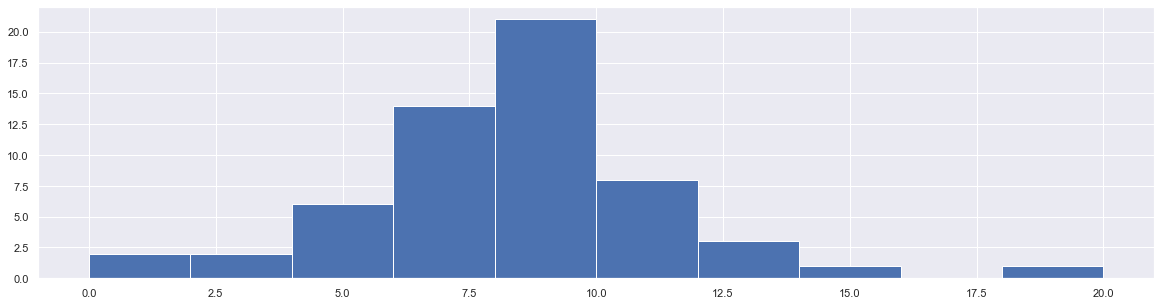

In [476]:
plt.hist(np.array(peaks_240)[:, 2])

(array([ 3.,  2.,  7., 10., 13.,  9.,  4.,  5.,  2.,  2.]),
 array([ 2. ,  3.4,  4.8,  6.2,  7.6,  9. , 10.4, 11.8, 13.2, 14.6, 16. ]),
 <BarContainer object of 10 artists>)

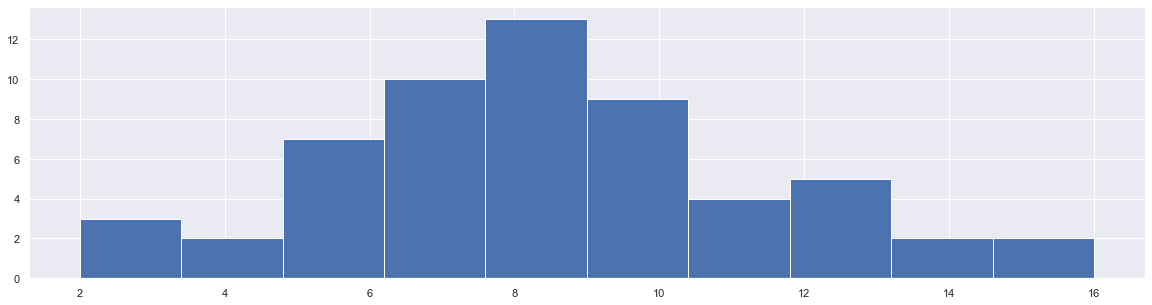

In [477]:
plt.hist(np.array(peaks_360)[:, 2])

(array([ 3.,  4.,  2., 14., 11., 12.,  6.,  4.,  0.,  2.]),
 array([ 4. ,  5.8,  7.6,  9.4, 11.2, 13. , 14.8, 16.6, 18.4, 20.2, 22. ]),
 <BarContainer object of 10 artists>)

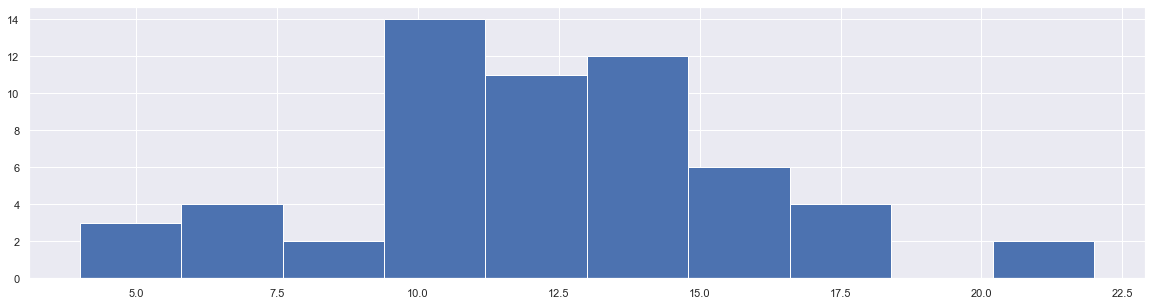

In [479]:
plt.hist(np.array(peaks_480)[:, 2])

(array([ 8., 10., 17., 14.,  6.,  0.,  1.,  0.,  0.,  1.]),
 array([ 8. , 14.4, 20.8, 27.2, 33.6, 40. , 46.4, 52.8, 59.2, 65.6, 72. ]),
 <BarContainer object of 10 artists>)

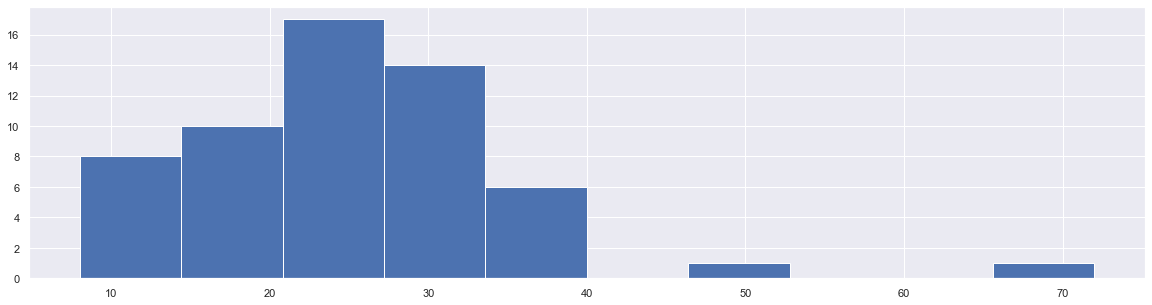

In [480]:
plt.hist(np.array(peaks_720)[:, 2])

(array([ 5., 11., 18.,  9., 10.,  2.,  0.,  1.,  0.,  1.]),
 array([ 11. ,  20.3,  29.6,  38.9,  48.2,  57.5,  66.8,  76.1,  85.4,
         94.7, 104. ]),
 <BarContainer object of 10 artists>)

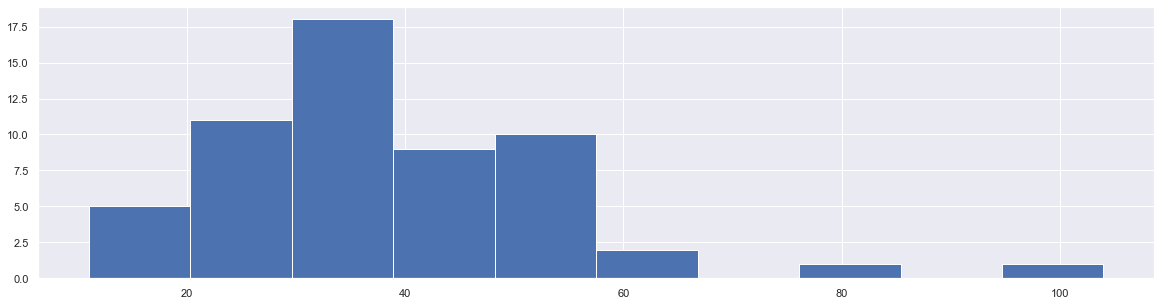

In [482]:
plt.hist(np.array(peaks_1080)[:, 2])

## Spectral Features

In [238]:
def explode_extended(df):
    """
    takes in a network-stats df and explodes the extended columns.
    time is converted from seconds to milliseconds.
    drop the ip address columns and the aggregate columns.
    """
    ext_col = ['packet_times', 'packet_sizes', 'packet_dirs']
    
    pre_explode = df[ext_col].apply(lambda x: x.str.split(';').str[:-1])
    
    exploded = pre_explode[ext_col].apply(lambda x: x.explode(ignore_index=True).astype(np.int64))
    exploded.columns = ['Time', 'pkt_size', 'pkt_dir']

    _sorted = exploded.sort_values('Time')
    _sorted['Time'] = pd.to_datetime(_sorted['Time'], unit='ms')

    return _sorted
  
def power_density(df, bins):
  
  f, Pxx = sp.signal.welch(df['pkt_size'], fs=2) 
  Pxx = np.sqrt(Pxx)
  freq = np.linspace(0, np.max(f) + .01, num=bins) - .001
  total = np.trapz(y=Pxx, x=f)
  temp_lst = []
  
  for i in np.arange(len(freq) - 1):

    f_lower = np.where(f >= freq[i])
    f_upper = np.where(f < freq[i+1] )
    selected_range = np.intersect1d(f_lower, f_upper)

    pxx_den = np.trapz(y=Pxx[selected_range], x=f[selected_range]) 
    pxx_max = np.max(Pxx[selected_range]) / np.sum(Pxx[selected_range])
    temp_lst.append(pxx_max)

  return temp_lst

In [ ]:
%%time
size='500ms'
resample_240 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_240_lst]
resample_360 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_360_lst]
resample_480 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_480_lst]
resample_720 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_720_lst]
resample_1080 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_1080_lst]

In [232]:
%%time
size='2000ms'

resample_240 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_240_lst]
resample_360 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_360_lst]
resample_480 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_480_lst]
resample_720 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_720_lst]
resample_1080 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_1080_lst]

Wall time: 23.4 s


In [ ]:
## area under the curve for a periodogram

In [239]:
bins = 3
pxx_den_240 = [power_density(df, bins) for df in resample_240]
pxx_den_360 = [power_density(df, bins) for df in resample_360]
pxx_den_480 = [power_density(df, bins) for df in resample_480]
pxx_den_720 = [power_density(df, bins) for df in resample_720]
pxx_den_1080 = [power_density(df, bins) for df in resample_1080]

pxx_den_df = pd.DataFrame({
  "240p": np.mean(pxx_den_240, axis=0),
  "360p": np.mean(pxx_den_360, axis=0),
  "480p": np.mean(pxx_den_480, axis=0),
  "720p": np.mean(pxx_den_720, axis=0),
  "1080p": np.mean(pxx_den_1080, axis=0)
}).T

#pxx_den_df.columns = ['[-.001, .086)', '[.086, .172)', '[.172, .259)']
pxx_den_df['St_dev'] = [
  np.mean(np.std(pxx_den_240, axis=1)),
  np.mean(np.std(pxx_den_360, axis=1)),
  np.mean(np.std(pxx_den_480, axis=1)),
  np.mean(np.std(pxx_den_720, axis=1)), 
  np.mean(np.std(pxx_den_1080, axis=1))]

pxx_den_df

,0,1,St_dev
240p,0.071342,0.059827,0.007103
360p,0.065298,0.056578,0.006932
480p,0.078809,0.061861,0.010060
720p,0.107265,0.080222,0.016865
1080p,0.097572,0.081536,0.020121


In [240]:
bins = 4
pxx_den_240 = [power_density(df, bins) for df in resample_240]
pxx_den_360 = [power_density(df, bins) for df in resample_360]
pxx_den_480 = [power_density(df, bins) for df in resample_480]
pxx_den_720 = [power_density(df, bins) for df in resample_720]
pxx_den_1080 = [power_density(df, bins) for df in resample_1080]

pxx_den_df = pd.DataFrame({
  "240p": np.mean(pxx_den_240, axis=0),
  "360p": np.mean(pxx_den_360, axis=0),
  "480p": np.mean(pxx_den_480, axis=0),
  "720p": np.mean(pxx_den_720, axis=0),
  "1080p": np.mean(pxx_den_1080, axis=0)
}).T

#pxx_den_df.columns = ['[-.001, .086)', '[.086, .172)', '[.172, .259)']
pxx_den_df['St_dev'] = [
  np.mean(np.std(pxx_den_240, axis=1)),
  np.mean(np.std(pxx_den_360, axis=1)),
  np.mean(np.std(pxx_den_480, axis=1)),
  np.mean(np.std(pxx_den_720, axis=1)), 
  np.mean(np.std(pxx_den_1080, axis=1))]

pxx_den_df

,0,1,2,St_dev
240p,0.105377,0.087410,0.086343,0.013373
360p,0.099245,0.079751,0.083677,0.013346
480p,0.125457,0.089805,0.089417,0.019731
720p,0.112274,0.115426,0.112140,0.025198
1080p,0.103900,0.105861,0.113787,0.024082


## Rolling Windows

In [492]:
size='2000ms'
resample_240 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_240_lst]
resample_360 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_360_lst]
resample_480 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_480_lst]
resample_720 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_720_lst]
resample_1080 = [explode_extended(df).resample(size, on='Time').sum() for df in chunk_1080_lst]

In [485]:
def rolling(df, sample_size):
  
  return df.rolling(sample_size).mean()

In [ ]:
def rolling_normalized_std(df, sample_size):
    
    df_roll = df.rolling(sample_size).std()
    
    roll_mean = df_roll['pkt_size'].mean()
    roll_std = df_roll['pkt_size'].std()

    normalized_std = roll_std / roll_mean

    return [normalized_std]#, roll_mean * mbit_rate, roll_std * mbit_rate]

In [484]:
window = 8
normalized_std_240 = [rolling_normalized_std(df, window) for df in resample_240]
normalized_std_360 = [rolling_normalized_std(df, window) for df in resample_360]
normalized_std_480 = [rolling_normalized_std(df, window) for df in resample_480]
normalized_std_720 = [rolling_normalized_std(df, window) for df in resample_720]
normalized_std_1080 = [rolling_normalized_std(df, window) for df in resample_1080]

In [506]:
rolling_240 = [rolling(df, 15)[15:] for df in resample_240]
rolling_360 = [rolling(df, 15)[15:] for df in resample_360]
rolling_480 = [rolling(df, 15)[15:] for df in resample_480]
rolling_720 = [rolling(df, 15)[15:] for df in resample_720]
rolling_1080 = [rolling(df, 15)[15:] for df in resample_1080]


In [507]:
bins = 4
pxx_den_240 = [power_density(df, bins) for df in rolling_240]
pxx_den_360 = [power_density(df, bins) for df in rolling_360]
pxx_den_480 = [power_density(df, bins) for df in rolling_480]
pxx_den_720 = [power_density(df, bins) for df in rolling_720]
pxx_den_1080 = [power_density(df, bins) for df in rolling_1080]

pxx_den_df = pd.DataFrame({
  "240p": np.mean(pxx_den_240, axis=0),
  "360p": np.mean(pxx_den_360, axis=0),
  "480p": np.mean(pxx_den_480, axis=0),
  "720p": np.mean(pxx_den_720, axis=0),
  "1080p": np.mean(pxx_den_1080, axis=0)
}).T

pxx_den_df

,0,1,2
240p,0.647366,0.195453,0.132967
360p,0.651172,0.195862,0.126516
480p,0.612207,0.222393,0.140349
720p,0.566269,0.241561,0.167288
1080p,0.579926,0.218942,0.178621


CoV on a rolling window average

In [ ]:
np.mean(normalized_std_240, axis=0)

In [ ]:
np.mean(normalized_std_360, axis=0)

In [ ]:
np.mean(normalized_std_480, axis=0)

In [ ]:
np.mean(normalized_std_720, axis=0)

In [ ]:
np.mean(normalized_std_1080, axis=0)

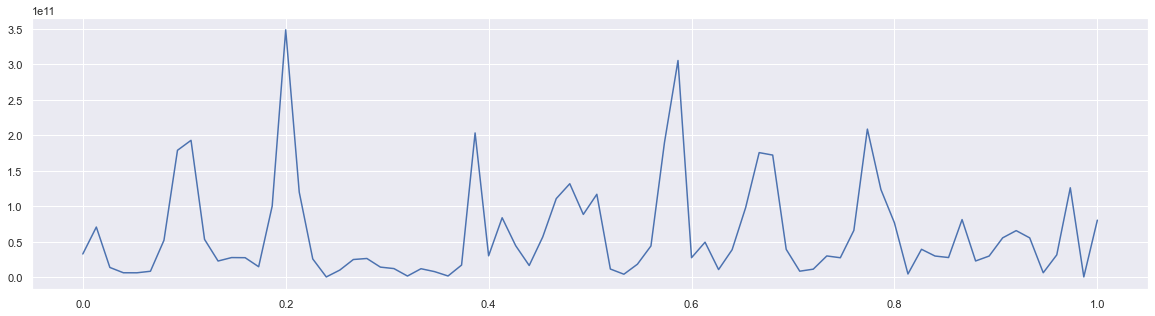

In [511]:
test = resample_240[0]
f_1s, psd_1s = sp.signal.welch(test['pkt_size'], fs=2)
plt.plot(f_1s, psd_1s)

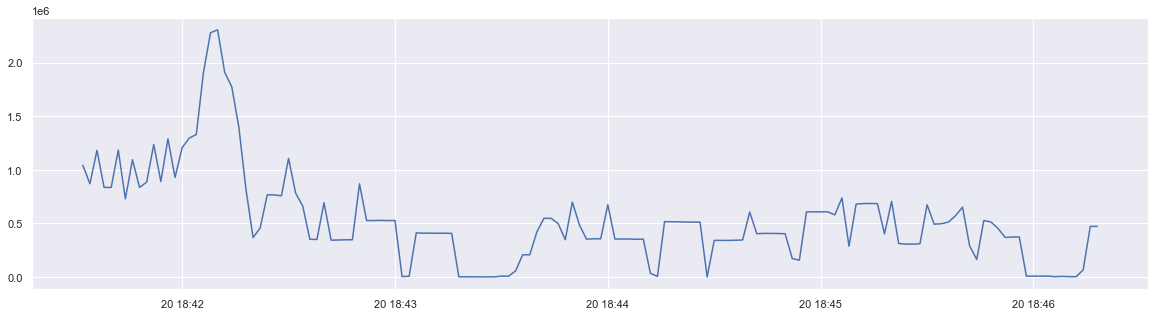

In [505]:
plt.plot(rolling_1080[5]['pkt_size'])

In [ ]:
def normalized_std(df, col_lst):
  df_avg = np.mean(df)
  df_std = np.std(df)
  
  return df_std[col_lst].values / df_avg[col_lst].values

In [ ]:
%%time
feat_lst = ['1->2Bytes', '2->1Bytes']

normalized_std_240 = [normalized_std(df, feat_lst) for df in chunk_240_lst]
normalized_std_360 = [normalized_std(df, feat_lst) for df in chunk_360_lst]
normalized_std_480 = [normalized_std(df, feat_lst) for df in chunk_480_lst]
normalized_std_720 = [normalized_std(df, feat_lst) for df in chunk_720_lst]
normalized_std_1080 = [normalized_std(df, feat_lst) for df in chunk_1080_lst]

cofficient of variation - download & upload

In [ ]:
np.mean(normalized_std_240, axis=0)

In [ ]:
np.mean(normalized_std_360, axis=0)

In [ ]:
np.mean(normalized_std_480, axis=0)

In [ ]:
np.mean(normalized_std_720, axis=0)

In [ ]:
np.mean(normalized_std_1080, axis=0)

difference in cofficient of variation between upload and download bytes

In [ ]:
np.mean(np.array(normalized_std_240)[:, 0] - np.array(normalized_std_240)[:, 1])

In [ ]:
np.mean(np.array(normalized_std_360)[:, 0] - np.array(normalized_std_360)[:, 1])

In [ ]:
np.mean(np.array(normalized_std_480)[:, 0] - np.array(normalized_std_480)[:, 1])

In [ ]:
np.mean(np.array(normalized_std_720)[:, 0] - np.array(normalized_std_720)[:, 1])

In [ ]:
np.mean(np.array(normalized_std_1080)[:, 0] - np.array(normalized_std_1080)[:, 1])

In [ ]:
%%time
size='1000ms'
resample_240 = [explode_extended(df) for df in chunk_240_lst]
resample_360 = [explode_extended(df) for df in chunk_360_lst]
resample_480 = [explode_extended(df) for df in chunk_480_lst]
resample_720 = [explode_extended(df) for df in chunk_720_lst]
resample_1080 = [explode_extended(df) for df in chunk_1080_lst]

In [ ]:
rolling_normalized_std(resample_240[3], 8)

## Chunking & Feature creation

In [21]:
def chunk_data(df, interval=120):

    """
    takes in a filepath to the data you want to chunk and feature engineer
    chunks our data into a specified time interval
    each chunk is then turned into an observation to be fed into our classifier
    """

    df_list = []
    
    df['Time'] = df['Time'] - df['Time'].min()
    
    total_chunks = np.floor(df['Time'].max() / interval).astype(int)

    for chunk in np.arange(total_chunks):
      
        start = chunk * interval
        end = (chunk+1) * interval

        temp_df = (df[(df['Time'] >= start) & (df['Time'] < end)])
        
        df_list.append(temp_df)
        
    return df_list

In [312]:
def get_peak_loc(df, col, invert=False):
  """
  invert arg allows you to get values not considered peaks
  """
  df_avg = df[col].mean()
  df_std = df[col].std()
  
  threshold = df_avg + (.5 * df_std)
  if invert:
    return np.array(df[col] < threshold)
  
  else:
    return np.array(df[col] > threshold)
  
def hard_threshold_peaks(df, col, thresh):
    x = df[col]
    peaks, _ = sp.signal.find_peaks(x, height=thresh)
    return peaks
  
def peak_features(df, col, threshold):
  """
  threshold is a megabit value that is converted to bytes
  """
  mbps_thresh = threshold * 125000
  #peaks = df[get_peak_loc(df, col)]
  peaks = df.iloc[hard_threshold_peaks(df, col, mbps_thresh)]
  peaks['Time'] = peaks['Time'] - peaks['Time'].min()
  time_diff = np.diff(peaks['Time'])
  if len(peaks) <= 0:
    return [-1, -1, 0, -1]
  
  return [np.mean(peaks)[col] * mbit_rate, np.std(peaks)[col] * mbit_rate, len(peaks), 120 / len(peaks)]

def explode_extended(df):
    """
    takes in a network-stats df and explodes the extended columns.
    time is converted from seconds to milliseconds.
    drop the ip address columns and the aggregate columns.
    """
    ext_col = ['packet_times', 'packet_sizes', 'packet_dirs']
    
    pre_explode = df[ext_col].apply(lambda x: x.str.split(';').str[:-1])
    
    exploded = pre_explode[ext_col].apply(lambda x: x.explode(ignore_index=True).astype(np.int64))
    exploded.columns = ['Time', 'pkt_size', 'pkt_dir']

    _sorted = exploded.sort_values('Time')
    _sorted['Time'] = pd.to_datetime(_sorted['Time'], unit='ms')

    return _sorted
  
def power_density(df, bins):
  
  f, psd = sp.signal.welch(df['pkt_size'], fs=.5) 
  psd = np.sqrt(psd)
  freq = np.linspace(0, np.max(f) + .01, num=bins) - .001
  total = np.trapz(y=psd, x=f)
  psd_den_lst = []
  
  for i in np.arange(len(freq) - 1):

    f_lower = np.where(f >= freq[i])
    f_upper = np.where(f < freq[i+1] )
    selected_range = np.intersect1d(f_lower, f_upper)

    psd_den = np.trapz(y=psd[selected_range], x=f[selected_range]) / total
    psd_den_lst.append(psd_den)

  return psd_den_lst

def rolling_normalized_std(df, sample_size):
    
    df_roll = df.rolling(sample_size).std()
    
    roll_mean = df_roll['pkt_size'].mean()
    roll_std = df_roll['pkt_size'].std()

    normalized_std = roll_std / roll_mean

    return [normalized_std]#, roll_mean * mbit_rate, roll_std * mbit_rate]
  
def normalized_std(df, col):
  df_avg = np.mean(df[col])
  df_std = np.std(df[col])
  
  return df_std / df_avg

In [384]:
def create_features(path, interval, threshold):
  vals = []
  
  mbit = 125000
  
  df = pd.read_csv(path)
  df_chunks = chunk_data(df, interval)

  for chunk in df_chunks:
    temp = []

    # average amount of bytes/second in a chunk
    download_avg = np.mean(chunk['2->1Bytes']) / mbit
    download_std = np.std(chunk['2->1Bytes']) / mbit
    #upload_avg = np.mean(chunk['1->2'])
    diff_pkts = np.std(chunk['2->1Pkts'] - chunk['1->2Pkts'])
    
    temp.append(download_avg)
    temp.append(download_std)
    temp.append(diff_pkts)
    
    # peak - average, # peaks, seconds:peak ratio
    peak_feats = peak_features(chunk, '2->1Bytes', threshold)
    temp.append(peak_feats)
    
    # spectral - density, standard deviation of densities 
    extended = explode_extended(chunk)
    resample_2s = extended.resample('2000ms', on='Time').sum()
    
    psd_density = power_density(resample_2s, 3)
    psd_density_stdev = np.std(psd_density)
    
#     temp.append(psd_density)
    temp.append(psd_density_stdev)
    
#     # coefficient of variation
    resample_1s = extended.resample('1000ms', on='Time').sum()
    rolling_cv = rolling_normalized_std(resample_1s, 8)
    temp.append(rolling_cv)
    
    diff_cv = normalized_std(chunk, '1->2Bytes') - normalized_std(chunk, '2->1Bytes')
    temp.append(diff_cv)
    
    chunk_feat = np.hstack(temp)
    vals.append(chunk_feat)
    
  return vals

In [470]:
%%time
size = 300
feat_240 = np.vstack(([create_features(fp, size, 5) for fp in two_four_path]))
feat_360 = np.vstack(([create_features(fp, size, 5) for fp in three_six_path]))
feat_480 = np.vstack(([create_features(fp, size, 5) for fp in four_eight_path]))
feat_720 = np.vstack(([create_features(fp, size, 5) for fp in seven_two_path]))
feat_1080 = np.vstack(([create_features(fp, size, 5) for fp in ten_eight_path]))

Wall time: 1min 7s


In [438]:
features = [
  "download_avg", 
  "download_std",
  "diff_pkts",
  "peak_avg",
  "peak_std",
  "peak_amount", 
  "seconds_per_peak", 
#   "psd_first_half", 
#   "psd_second_half", 
  "psd_std", 
  "rolling_cv", 
  "diff_bytes_cv"
]

feat_df_240 = pd.DataFrame(columns=features, data=feat_240)
feat_df_240['resolution'] = 1

feat_df_360 = pd.DataFrame(columns=features, data=feat_360)
feat_df_360['resolution'] = 2

feat_df_480 = pd.DataFrame(columns=features, data=feat_480)
feat_df_480['resolution'] = 3

feat_df_720 = pd.DataFrame(columns=features, data=feat_720)
feat_df_720['resolution'] = 4

feat_df_1080 = pd.DataFrame(columns=features, data=feat_1080)
feat_df_1080['resolution'] = 5

In [439]:
training = pd.concat((
  feat_df_240,
  feat_df_360,
  feat_df_480,
  feat_df_720,
  feat_df_1080
))


In [440]:
training.corr()['resolution']

download_avg        0.708073
download_std        0.766143
diff_pkts           0.737810
peak_avg            0.494265
peak_std            0.411986
peak_amount         0.691184
seconds_per_peak   -0.567023
psd_std             0.401234
rolling_cv         -0.562007
diff_bytes_cv       0.404209
resolution          1.000000
Name: resolution, dtype: float64

In [441]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, make_scorer

In [442]:
scaler = StandardScaler()
for feat in training.columns:
    if feat == "resolution":
        continue
    training[feat] = scaler.fit_transform(np.array(training[feat]).reshape(-1, 1))

In [452]:
X, y = training.drop(columns=['resolution']), training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8,  stratify=training['resolution'])

In [466]:
clf = RandomForestClassifier(n_estimators = 15, max_depth = 15, criterion = 'gini', min_samples_split = 2, random_state = 42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=15, random_state=42)

In [467]:
y_pred = clf.predict(X_test)

In [468]:
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

Predicted Resolution,1,2,3,4,5
Actual Resolution,,,,,
1,24,4,1,0,0
2,3,22,5,0,0
3,0,5,22,3,0
4,0,1,3,22,3
5,0,1,2,2,24


In [469]:
accuracy_score(y_test, y_pred)

0.7755102040816326

In [436]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in indices:
    print(features[i],': ',importances[i])

peak_avg :  0.1709780141934423
rolling_cv :  0.12606776866717806
download_std :  0.12127064257145087
seconds_per_peak :  0.1199981510220573
peak_amount :  0.08905715713375068
download_avg :  0.08794356670115924
psd_std :  0.08072086640134644
diff_pkts :  0.07683943841228803
peak_std :  0.06941945183534073
diff_bytes_cv :  0.05770494306198636


In [355]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, make_scorer

In [356]:
%%time
rf_clf = RandomForestClassifier(random_state=42)
parameters_rf = {"n_estimators": [4, 5, 6, 7, 8, 9, 10, 15], "criterion": ["entropy"], "max_features": ["auto"], 
                 "max_depth": [2, 3, 5, 10], "min_samples_split": [2, 3, 5, 10]}

grid_rf = GridSearchCV(rf_clf, parameters_rf, scoring=make_scorer(accuracy_score))
grid_rf.fit(X_train, y_train)

rf_clf = grid_rf.best_estimator_

rf_clf.fit(X_train, y_train)
pred_rf = rf_clf.predict(X_test)
acc_rf = accuracy_score(y_test, pred_rf)

print("The Score for Random Forest is: " + str(acc_rf))

The Score for Random Forest is: 0.7011494252873564
Wall time: 37.2 s


In [89]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

parameters_knn = {"n_neighbors": [3, 5, 10, 15], "weights": ["uniform", "distance"], "algorithm": ["auto", "ball_tree", "kd_tree"],
                  "leaf_size": [20, 30, 50]}

grid_knn = GridSearchCV(knn_clf, parameters_knn, scoring=make_scorer(accuracy_score))
grid_knn.fit(X_train, y_train)

knn_clf = grid_knn.best_estimator_

knn_clf.fit(X_train, y_train)
pred_knn = knn_clf.predict(X_test)
acc_knn = accuracy_score(y_test, pred_knn)

print("The Score for KNeighbors is: " + str(acc_knn))

The Score for KNeighbors is: 0.6193181818181818


In [90]:
training

,download_avg,download_std,diff_pkts,peak_avg,peak_std,peak_amount,seconds_per_peak,psd_std,rolling_cv,diff_bytes_cv,resolution
0,0.493287,1.510191,58.821310,4.507905,1.912997,19.0,6.315789,0.015205,0.926742,-0.181823,1
1,0.302967,1.312258,46.749896,5.294754,2.047092,9.0,13.333333,0.003586,1.278257,-0.682727,1
2,0.435905,1.664388,78.043282,5.951872,2.296883,8.0,15.000000,0.013245,1.251495,-0.706401,1
3,0.478153,1.492012,49.934867,4.803225,1.413974,9.0,13.333333,0.078491,1.329746,-0.211040,1
4,0.363659,1.398493,61.132498,4.834723,2.133572,8.0,15.000000,0.011252,1.328031,-0.623883,1
...,...,...,...,...,...,...,...,...,...,...,...
112,2.448724,5.436599,253.678792,14.399371,4.469455,18.0,6.666667,0.023839,0.465408,-0.144615,5
113,2.247758,4.905930,229.184704,12.422348,4.177222,20.0,6.000000,0.047994,0.521474,-0.157645,5
114,1.887700,4.319024,202.057002,10.169865,4.214761,21.0,5.714286,0.014442,0.699987,-0.231061,5
115,1.800994,4.528866,211.316294,11.009549,5.171917,19.0,6.315789,0.002683,0.944510,-0.196947,5


In [ ]:
## wip; need to decide chunk size eventually
## should we also make this chunking feature be our feature creation?

def chunk_data(df, interval=120):

    """
    takes in a filepath to the data you want to chunk and feature engineer
    chunks our data into a specified time interval
    each chunk is then turned into an observation to be fed into our classifier
    """

    df_list = []
    
    df['Time'] = df['Time'] - df['Time'].min()
    
    total_chunks = np.floor(df['Time'].max() / interval).astype(int)

    for chunk in np.arange(total_chunks):
      
        start = chunk * interval
        end = (chunk+1) * interval

        temp_df = (df[(df['Time'] >= start) & (df['Time'] < end)])
        
        df_list.append(temp_df)
        
    return df_list

In [ ]:
def create_features(df, interval=60):

  features = [
    'dwl_peak_freq',
    'dwl_peak_prom',
    'dwl_max_psd',
    'dwl_bytes_avg',
    'dwl_bytes_std',
    'dwl_peak_avg',
    'dwl_peak_var',
    'dwl_peak_std',
    'upl_peak_freq',
    'upl_peak_prom',
    'upl_max_psd',
    'upl_bytes_avg',
    'upl_bytes_std',
    'upl_peak_avg',
    'upl_peak_var',
    'upl_peak_std',
    'IMAN_dwn_time_peak',#'IMAN_up_time_peak',
    'IMAN_dwn_num_peak'#,'IMAN_up_num_peak'
  ]  

  vals = []

  df_chunks = chunk_data(df, interval)

  for chunk in df_chunks:

    preproc = convert_ms_df(chunk, True)
    upl_bytes = preproc[preproc['pkt_src'] == '1'].resample('500ms', on='Time').sum()
    dwl_bytes = preproc[preproc['pkt_src'] == '2'].resample('500ms', on='Time').sum()

    ## spectral features
    dwl_spectral = spectral_features(dwl_bytes, 'pkt_size')
    upl_spectral = spectral_features(upl_bytes, 'pkt_size')
    
    ## aggregate features
    dwl_agg = agg_feat(chunk, '2->1Bytes')
    upl_agg = agg_feat(chunk, '1->2Bytes')
    
    ## peak features
    dwl_peak = peak_time_diff(chunk, '2->1Bytes')
    upl_peak = peak_time_diff(chunk, '1->2Bytes')
    
    ## iman's time between peak 
    iman_dwn_time_peak = np.mean(peak_times(chunk,'2->1Bytes',1000000))
    #iman_up_time_peak = np.mean(peak_times(chunk,'1->2Bytes',50000))

    ## iman's num peak
    iman_dwn_num_peak = num_peaks(chunk,'2->1Bytes',1000000)
    #iman_up_num_peak = num_peaks(chunk,'1->2Bytes',50000)

    feat_val = np.hstack((
      dwl_spectral,
      dwl_agg,
      dwl_peak,
      upl_spectral,
      upl_agg,
      upl_peak,
      iman_dwn_time_peak,
      #iman_up_time_peak,
      iman_dwn_num_peak,
      #iman_up_num_peak
    ))
    
    vals.append(feat_val)
    
  return pd.DataFrame(columns=features, data=vals).fillna(0)

In [ ]:
def create_features_no_split(df, interval=60):

  features = [
    'peak_freq',
    'peak_prom',
    'max_psd',
    'bytes_avg',
    'bytes_std',
    'peak_avg',
    'peak_var',
    'peak_std',
  ]  

  vals = []

  df_chunks = chunk_data(df, interval)

  for chunk in df_chunks:

    preproc = convert_ms_df(chunk, True)

    ## spectral features
    spectral_feat = spectral_features(preproc, 'pkt_size')
    
    ## aggregate features
    aggr_feat = agg_feat(chunk, '2->1Bytes')
    
    ## peak features
    peak_feat = peak_time_diff(chunk, '2->1Bytes')
    
    feat_val = np.hstack((
      spectral_feat,
      aggr_feat,
      peak_feat
    ))
    
    vals.append(feat_val)
    
  return pd.DataFrame(columns=features, data=vals).fillna(0)

In [ ]:
low_feat_no_split = create_features_no_split(stdoan_low, 100)

## Dev Playground

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [ ]:
%%time
low_feat = pd.concat([create_features(df, 100) for df in low_dfs])
med_feat = pd.concat([create_features(df, 100) for df in med_dfs])
high_feat = pd.concat([create_features(df, 100) for df in high_dfs])

In [ ]:
low_feat['resolution'] = np.zeros(len(low_feat))
med_feat['resolution'] = np.zeros(len(med_feat)) + 1
high_feat['resolution'] = np.zeros(len(high_feat)) + 2

In [ ]:
training_split = pd.concat([low_feat, med_feat, high_feat])

In [ ]:
X, y = training_split.drop(columns=['resolution']), training_split['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 8)

In [ ]:
clf_split = RandomForestClassifier(n_estimators = 5, max_depth = 2, criterion = 'entropy', random_state = 42)
clf_split.fit(X_train, y_train)

In [ ]:
y_pred = clf_split.predict(X_test)

In [ ]:
np.abs(training_split.corr()['resolution']).sort_values(ascending=False)

In [ ]:
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

In [ ]:
f1_score(y_test, y_pred, average=None)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
features = [
  'dwl_peak_freq',
  'dwl_peak_prom',
  'dwl_max_psd',
  'dwl_bytes_avg',
  'dwl_bytes_std',
  'dwl_peak_avg',
  'dwl_peak_var',
  'dwl_peak_std',
  'upl_peak_freq',
  'upl_peak_prom',
  'upl_max_psd',
  'upl_bytes_avg',
  'upl_bytes_std',
  'upl_peak_avg',
  'upl_peak_var',
  'upl_peak_std',
  'IMAN_dwn_time_peak',#'IMAN_up_time_peak'
            'IMAN_dwn_num_peak']#,'IMAN_up_num_peak']
importances = clf_split.feature_importances_
indices = np.argsort(importances)[::-1]
for i in indices:
    print(features[i],': ',importances[i])
    

In [ ]:
import dill

In [ ]:
dill.dump(clf_split, open("randomforest_chkpt2.obj", "wb"))

In [ ]:
dill.load(open("randomforest_chkpt2.obj", "rb"))

In [ ]:
pip install scikit-learn

## no split (download focus)

In [ ]:
%%time
low_feat_no_split = create_features_no_split(stdoan_low, 100)
med_feat_no_split = create_features_no_split(stdoan_med, 100)
high_feat_no_split = create_features_no_split(stdoan_high, 100)

In [ ]:
low_feat_no_split['resolution'] = np.zeros(len(low_feat))
med_feat_no_split['resolution'] = np.zeros(len(med_feat)) + 1
high_feat_no_split['resolution'] = np.zeros(len(high_feat)) + 2

In [ ]:
training_no_split = pd.concat([low_feat_no_split, med_feat_no_split, high_feat_no_split])

In [ ]:
X, y = training_no_split.drop(columns=['resolution']), training_no_split['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 8)

In [ ]:
clf_no_split = RandomForestClassifier(n_estimators = 2, max_depth = 2, criterion = 'entropy', random_state = 42)
clf_no_split.fit(X_train, y_train)

In [ ]:
y_pred = clf_no_split.predict(X_test)

In [ ]:
np.abs(training_no_split.corr()['resolution']).sort_values(ascending=False)

In [ ]:
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

In [ ]:
f1_score(y_test, y_pred, average=None)